# Stage 0: SETUP
The following libraries are used directly. For the full list of installed packages and versions, please see requirements.txt

In [1]:
# Imports
import pandas as pd
import numpy as np

# Stage 1: DATA ACQUISITION

Data is downloaded as csv files, and is already available in this repository in the data folder. See the readme for details on the source of the data.

## Case Data
Case data is provided with dates as columns. For processing, the data is melted into a "date" column and "case_count" column, and unused columns are dropped.

In [2]:
# Get raw data, only keep used columns
raw_case_data = pd.read_csv('data/raw/RAW_us_confirmed_cases.csv').drop(columns = ["Province_State", "Admin2", "UID", "iso2", "iso3", "Country_Region", "Lat", "Long_", "code3", "Combined_Key"])


# Pivot into dat column
case_data = raw_case_data.melt(id_vars = "FIPS", var_name="date", value_name = "Case_Count")

# Cast types
case_data["date"] = pd.to_datetime(case_data["date"])
case_data.head()


,FIPS,date,Case_Count
0,1001.0,2020-01-22,0
1,1003.0,2020-01-22,0
2,1005.0,2020-01-22,0
3,1007.0,2020-01-22,0
4,1009.0,2020-01-22,0


## Mandate Data
The Mandate Data contains separate FIPS_State and FIPS_County columns, that must be combined into a FIPS column during procesinsg. Unused columns are dropped.

In [3]:
# Get raw data
raw_mandate_data = pd.read_csv('data/raw/public_mask_mandates_by_day.csv')

# Calcualte FIPS and cast to date
raw_mandate_data["FIPS"] = raw_mandate_data["FIPS_State"]*1000 + raw_mandate_data["FIPS_County"]
raw_mandate_data["date"] = pd.to_datetime(raw_mandate_data["date"])
raw_mandate_data["mask_mandate"] = (raw_mandate_data["Face_Masks_Required_in_Public"] == "Yes").astype(int)
raw_mandate_data["mask_mandate"].fillna(0, inplace=True)

# Remove unused columns
mandate_data = raw_mandate_data[["FIPS", "date", "mask_mandate"]]

mandate_data.head()

,FIPS,date,mask_mandate
0,1001,2020-04-10,0
1,1001,2020-04-11,0
2,1001,2020-04-12,0
3,1001,2020-04-13,0
4,1001,2020-04-14,0


## Compliance Data


In [4]:
# Get raw data
raw_compliance_data = pd.read_csv('data/raw/mask_use_by_county.csv')

raw_compliance_data.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


# Stage 2: DATA PROCESSING

Here we filter down to the target county and combine data

In [5]:
# Combine on date and FIPS
combined_data = case_data.merge(mandate_data, on=["date", "FIPS"], how='left')

<AxesSubplot:xlabel='date'>

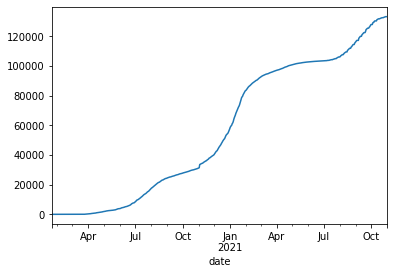

In [6]:
# Gwinnet County
target_fip = 13135
target_pop = 957062

# Combine on date
combined_data_county = combined_data[combined_data["FIPS"] == target_fip]

# Keep only data
county_data = combined_data_county[["date", "Case_Count", "mask_mandate", "FIPS"]].copy()
county_data["Pop"] = target_pop
county_data.set_index("date")["Case_Count"].plot()

Add in neighboring states that had a mask mandate so that we have a comparison


In [7]:
# Neighbor data (pop from US census 2020)
neighbors = [
    {"state":"NC", "FIP":37, "Pop": 10439388 },
    {"state":"AL", "FIP":1, "Pop": 5024279 }
]

# Aggregate
neighbor_fips = [row["FIP"] for row in neighbors]
neighbor_data = combined_data[(combined_data["FIPS"] // 1000).isin(neighbor_fips)].copy()
neighbor_data = neighbor_data.groupby("date").aggregate({"Case_Count": "sum", "mask_mandate":"mean"}).reset_index()
neighbor_data["Pop"] = np.sum([row["Pop"] for row in neighbors])
neighbor_data.head()

,date,Case_Count,mask_mandate,Pop
0,2020-01-22,0,NaN,15463667
1,2020-01-23,0,NaN,15463667
2,2020-01-24,0,NaN,15463667
3,2020-01-25,0,NaN,15463667
4,2020-01-26,0,NaN,15463667


# Stage 3: MODELING

Here we model infection rates and case counts.

In [21]:
def calculateSpreadRate(df, active_window = 10, smoothing = 14):
    df = df.set_index("date")
    
    # Extra calcs
    df["new_cases"] = df["Case_Count"].diff()
    df["vulnerable_pop"] = df["Pop"] - df["Case_Count"]
    
    # Infection rate is new over vulnerable
    df["active_cases"] = df["new_cases"].rolling(window=14).sum()
    df["infection_rate"] = df["new_cases"] / df["vulnerable_pop"]# / df["active_cases"]
    df["infection_rate_7da"] = df["infection_rate"].rolling(window=7).mean()
    df["infection_rate_change"] = df["infection_rate_7da"].diff()
    df["infection_rate_change_smooth"] = df["infection_rate_change"].rolling(window=smoothing).mean() * 1000000
    
    
    return df
    
    
    
    
calculateSpreadRate(county_data) 

,Case_Count,mask_mandate,FIPS,Pop,new_cases,vulnerable_pop,active_cases,infection_rate,infection_rate_7da,infection_rate_change,infection_rate_change_smooth
date,,,,,,,,,,,
2020-01-22,0,NaN,13135.0,957062,NaN,957062,NaN,NaN,NaN,NaN,NaN
2020-01-23,0,NaN,13135.0,957062,0.0,957062,NaN,0.000000,NaN,NaN,NaN
2020-01-24,0,NaN,13135.0,957062,0.0,957062,NaN,0.000000,NaN,NaN,NaN
2020-01-25,0,NaN,13135.0,957062,0.0,957062,NaN,0.000000,NaN,NaN,NaN
2020-01-26,0,NaN,13135.0,957062,0.0,957062,NaN,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,132879,NaN,13135.0,957062,142.0,824183,1629.0,0.000172,0.000125,1.946932e-07,-0.015387
2021-10-28,133024,NaN,13135.0,957062,145.0,824038,1546.0,0.000176,0.000131,6.431613e-06,-0.009097
2021-10-29,133120,NaN,13135.0,957062,96.0,823942,1471.0,0.000117,0.000123,-8.300865e-06,-0.008533


<AxesSubplot:xlabel='date'>

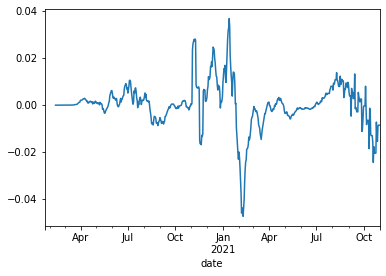

In [22]:
county_rates = calculateSpreadRate(county_data)
county_rates["infection_rate_change_smooth"].plot()

<AxesSubplot:xlabel='date'>

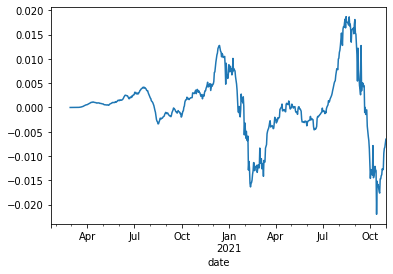

In [23]:
neighbor_rates = calculateSpreadRate(neighbor_data, smoothing=30)
neighbor_rates["infection_rate_change_smooth"].plot()

<AxesSubplot:xlabel='date'>

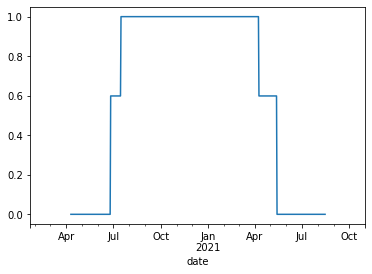

In [11]:
calculateSpreadRate(neighbor_data)["mask_mandate"].plot()

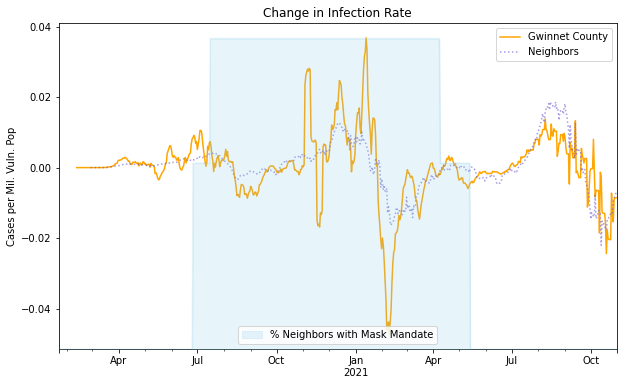

In [40]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
fig.set_size_inches(10, 6, forward=True)
#fig.autofmt_xdate()

# PLot rates
county_rates["infection_rate_change_smooth"].plot(label="Gwinnet County", color="orange")
neighbor_rates["infection_rate_change_smooth"].plot(label="Neighbors", color="slateblue", alpha=0.6, linestyle='dotted')
plt.ylabel("Cases per Mil. Vuln. Pop")
plt.xlabel("")
plt.legend()

#PLot mask usage
ax2=ax.twinx()
neighbor_rates["mask_mandate"].plot.area(color="skyblue", alpha=0.2, label="% Neighbors with Mask Mandate")
plt.axis('off')
plt.legend()

# Annotation
plt.title(label = "Change in Infection Rate")
#plt.show()
plt.savefig('Change_in_infection_rate.png')


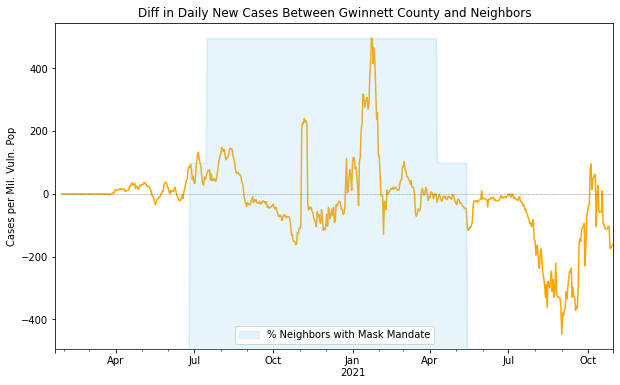

In [47]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

# Find diff
infection_rate_diff = (county_rates["infection_rate_7da"] - neighbor_rates["infection_rate_7da"]) * 1000000
zero = infection_rate_diff * 0

# PLot rates
infection_rate_diff.plot(label="Infection Rate Difference", color="orange")
zero.plot(color="black", linewidth=0.5, linestyle='dashed', alpha=0.5)
plt.ylabel("Cases per Mil. Vuln. Pop")
plt.xlabel("")

#PLot mask usage
ax2=ax.twinx()
neighbor_rates["mask_mandate"].plot.area(color="skyblue", alpha=0.2, label="% Neighbors with Mask Mandate")
plt.axis('off')
plt.legend()

#Anotate
plt.title(label = "Diff in Daily New Cases Between Gwinnett County and Neighbors")
#plt.show()
plt.savefig('Diff_in_infection_rate.png')